In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
  
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
   
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

In [3]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [4]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])




In [5]:
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])



In [6]:
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0]))

Number of samples in train and validation are 140 and 60.


In [7]:
import random

from scipy import ndimage
@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [8]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


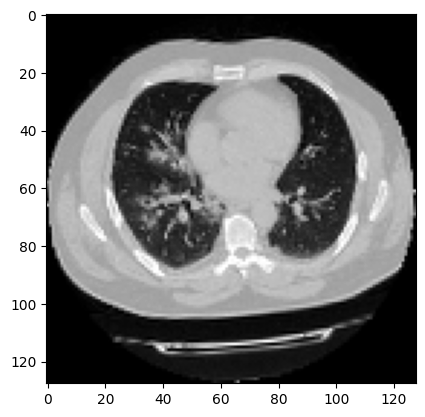

In [9]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [11]:
def get_model(width=128, height=128, depth=64):
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [12]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)


In [13]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [17]:
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Epoch 1/100
70/70 [==============================] - 1680s 24s/step - loss: 0.6949 - acc: 0.5571 - val_loss: 0.7105 - val_acc: 0.5000
Epoch 2/100
70/70 [==============================] - 1720s 25s/step - loss: 0.6242 - acc: 0.6500 - val_loss: 0.7583 - val_acc: 0.5000
Epoch 3/100
70/70 [==============================] - 1728s 25s/step - loss: 0.6509 - acc: 0.6000 - val_loss: 2.0500 - val_acc: 0.5000
Epoch 4/100
70/70 [==============================] - 1616s 23s/step - loss: 0.6543 - acc: 0.6071 - val_loss: 1.5216 - val_acc: 0.5000
Epoch 5/100
70/70 [==============================] - 1603s 23s/step - loss: 0.6453 - acc: 0.6286 - val_loss: 1.1985 - val_acc: 0.5000
Epoch 6/100
70/70 [==============================] - 1590s 23s/step - loss: 0.6181 - acc: 0.6643 - val_loss: 0.9244 - val_acc: 0.5000
Epoch 7/100
70/70 [==============================] - 1476s 21s/step - loss: 0.6585 - acc: 0.5786 - val_loss: 0.9364 - val_acc: 0.5000
Epoch 8/100
70/70 [==============================] - 1554s 22s

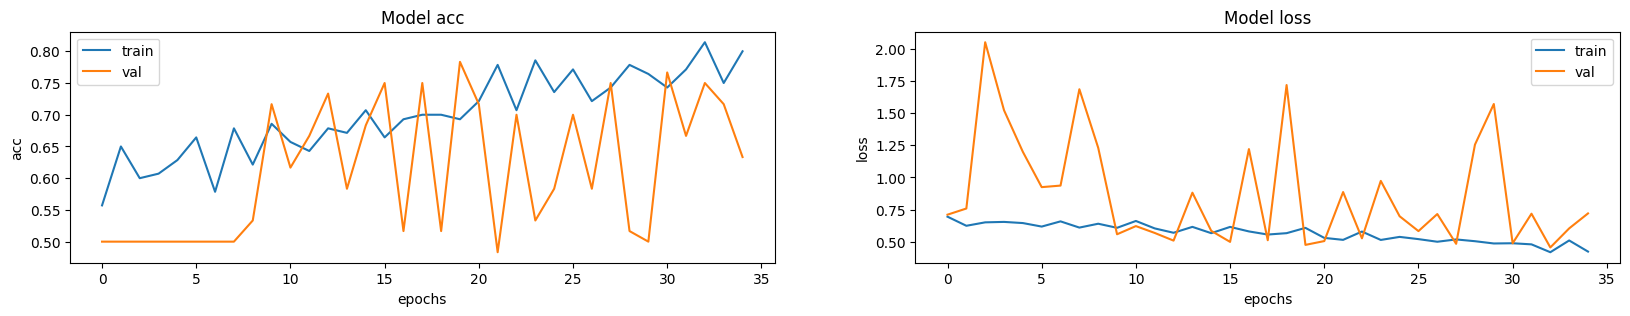

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")0
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:

import joblib
import pickle

In [21]:
filename = "3d_model.joblib"
joblib.dump(model, filename)

['3d_model.joblib']

In [1]:
import joblib
import matplotlib.pyplot as plt
import pickle
import numpy as np 
import tensorflow as tf

In [4]:
path1=r"D:\dataset\data\MosMedData\CT-23\study_0943.nii.gz"

processed= process_scan(path1) 

In [9]:
loaded_model = joblib.load("3d_model.joblib")
#loaded_model.load_weights("3d_image_classification.h5")
prediction = loaded_model.predict(np.expand_dims(processed, axis=0))[0]

print(prediction[0])
scores = [1 - prediction[0], prediction[0]]
output = max(scores)


for score, name in zip(scores, class_names):
    if(score == output):
        print(
            "This model is %.2f percent confident that CT scan is %s"
            % ((100 * score), name)
        )

1/1 [==============================] - 1s 790ms/step
0.8609211
This model is 86.09 percent confident that CT scan is malignant


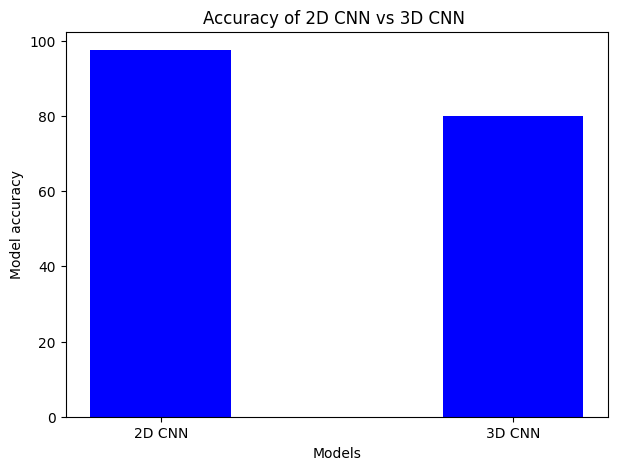

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data = {'2D CNN':97.5,'3D CNN':80}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (7, 5))

# creating the bar plot
plt.bar(courses, values, color ='blue',width = 0.4)

plt.xlabel("Models")
plt.ylabel("Model accuracy")
plt.title("Accuracy of 2D CNN vs 3D CNN ")
plt.show()
